In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [54]:
from Data.DatasetSupplier import DatasetSupplier
from Data.PatchFeatureExtractor import PatchFeatureExtractor
from Data.PatchDatasetGenerator import PatchIndexFinder
from Util.ImageLoader import ImageLoader
import os
import numpy as np
from Data.Preprocessing import ImagePreprocessing
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
dataset = DatasetSupplier.get_dataset()

In [4]:
test_names = ['images/pictures\\02_g.JPG', 'images/pictures\\09_g.JPG', 'images/pictures\\01_h.JPG','images/pictures\\05_dr.JPG', 'images/pictures\\13_dr.JPG', 'images/pictures\\08_h.JPG', 'images/pictures\\02_dr.JPG']
test_names = [name.lower() for name in test_names]

In [5]:
test_data = []
train_data = []

for data in dataset:
    if data[1].lower() in test_names:
        test_data.append(data)
    else:
        train_data.append(data)

In [7]:
print(len(test_data), len(train_data))

7 35


In [8]:
images_paths = [item[1] for item in train_data]
manual_paths = [item[2] for item in train_data]
masks_paths = [item[3] for item in train_data]

images_list = ImageLoader.load_images(images_paths, BGRtoRGB=True)
manual_list = ImageLoader.load_images(manual_paths)
masks_list = ImageLoader.load_images(masks_paths)

images = np.stack(images_list)
manual = np.stack(manual_list)
masks = np.stack(masks_list)

In [9]:
print(images.shape, manual.shape, masks.shape)

(35, 2336, 3504, 3) (35, 2336, 3504) (35, 2336, 3504, 3)


In [ ]:
# TODO also process the test images

def preprocessing(image):
    clahe = ImagePreprocessing.apply_clahe(image)
    median_filtered = ImagePreprocessing.median_filter(clahe)
    normalized = ImagePreprocessing.normalize(median_filtered)
    return normalized

In [31]:
images_processed = np.stack([preprocessing(img) for img in images])

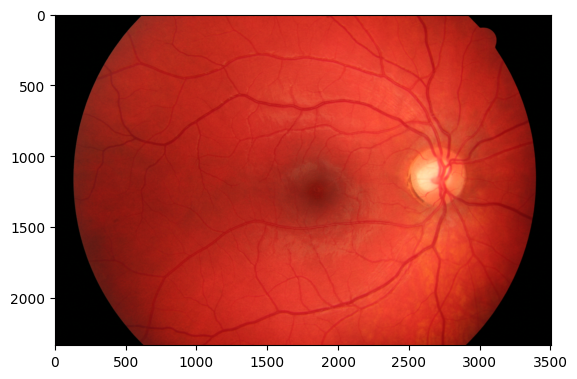

In [32]:
plt.imshow(images[5])

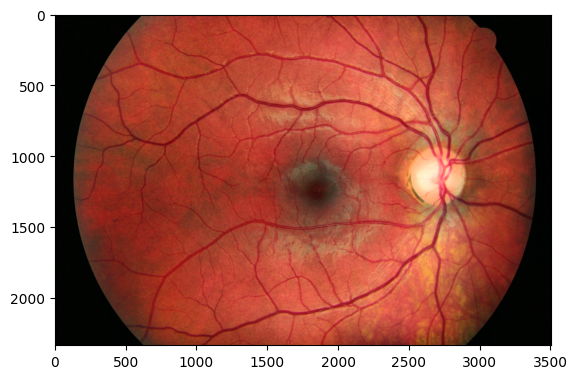

In [33]:
plt.imshow(images_processed[5])

In [34]:
images_resized = np.stack([ImagePreprocessing.resize_and_normalize(image) for image in images_processed])
manual_resized = np.stack([ImagePreprocessing.resize_and_normalize(man) for man in manual])
masks_resized = np.stack([ImagePreprocessing.resize_and_normalize(mask) for mask in masks])

In [35]:
print(images_resized.shape, manual_resized.shape, masks_resized.shape)

(35, 512, 512, 3) (35, 512, 512) (35, 512, 512, 3)


In [86]:
pfe = PatchFeatureExtractor()


#patches_, lables_ = pfe.extract_patches([images[0]], [manual[0]], [masks[0]], patch_size=5, patches_per_class=10)
patches, lables = pfe.extract_patches(images_resized, manual_resized, masks_resized, patch_size=5, patches_per_class=100000)

Number of valid patch centers: 217630
Number of valid patch centers: 217692
Number of valid patch centers: 217667
Number of valid patch centers: 217733
Number of valid patch centers: 217682
Number of valid patch centers: 217602
Number of valid patch centers: 217664
Number of valid patch centers: 217632
Number of valid patch centers: 217640
Number of valid patch centers: 217689
Number of valid patch centers: 217614
Number of valid patch centers: 217663
Number of valid patch centers: 217638
Number of valid patch centers: 217591
Number of valid patch centers: 217710
Number of valid patch centers: 217664
Number of valid patch centers: 217632
Number of valid patch centers: 217667
Number of valid patch centers: 217662
Number of valid patch centers: 217635
Number of valid patch centers: 217673
Number of valid patch centers: 217600
Number of valid patch centers: 217661
Number of valid patch centers: 217647
Number of valid patch centers: 217609
Number of valid patch centers: 217680
Number of va

In [48]:
print(patches.shape, lables.shape)
print(np.count_nonzero(lables))
with open('patches.pkl', 'wb') as f:
    pickle.dump(patches, f)

(99960, 5, 5, 3) (99960,)
49980


In [60]:
def feature_csv_header(patch_shape):
    """
    Returns a list of CSV header names for all features extracted by extract_features:
    - color variance (per channel)
    - central moments (3 per channel + 3 for grayscale)
    - Hu moments (7 per channel + 7 for grayscale)
    """
    h, w, c = patch_shape
    header = []

    # Color variance
    for ch in range(c):
        header.append(f'var_ch{ch+1}')

    # Central moments (per channel)
    for ch in range(c):
        for m in ['mu20', 'mu11', 'mu02']:
            header.append(f'central_{m}_ch{ch+1}')
    # Central moments (gray)
    for m in ['mu20', 'mu11', 'mu02']:
        header.append(f'central_{m}_gray')

    # Hu moments (per channel)
    for ch in range(c):
        for i in range(1, 8):
            header.append(f'hu{i}_ch{ch+1}')
    # Hu moments (gray)
    for i in range(1, 8):
        header.append(f'hu{i}_gray')

    return header

header = feature_csv_header((5,5,3))

In [87]:
features = [pfe.extract_features(patch) for patch in patches]

In [88]:
features_stack = np.stack(features)

In [89]:
print(features_stack.shape)

(99960, 43)


In [ ]:
with open('features.pkl', 'wb') as f:
    pickle.dump(features_stack, f)

(99960, 43)


In [50]:
with open('labels.pkl', 'wb') as f:
    pickle.dump(lables, f)

In [90]:
# Create a pandas DataFrame from features_stack
# We'll use the header we defined earlier but exclude 'img_path' as we don't have that information per patch
features_df = pd.DataFrame(features_stack, columns=header)  # exclude 'img_path' and 'label'

# Display basic info about the dataframe
print(f"DataFrame shape: {features_df.shape}")

# Show first few rows of the dataframe
features_df.describe()

DataFrame shape: (99960, 43)


,var_ch1,var_ch2,var_ch3,central_mu20_ch1,central_mu11_ch1,central_mu02_ch1,central_mu20_ch2,central_mu11_ch2,central_mu02_ch2,central_mu20_ch3,...,hu5_ch3,hu6_ch3,hu7_ch3,hu1_gray,hu2_gray,hu3_gray,hu4_gray,hu5_gray,hu6_gray,hu7_gray
count,9.996000e+04,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,...,9.996000e+04,9.996000e+04,9.996000e+04,99960.000000,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04
mean,1.296139e-03,0.002894,0.000446,33.718259,-0.003755,33.752191,15.116800,-0.014541,15.199356,9.226704,...,7.866419e-06,4.199503e-05,-1.301986e-06,0.564065,1.249003e-03,5.109584e-04,7.090200e-04,1.825029e-06,2.897599e-05,-1.120654e-07
std,1.758547e-03,0.004141,0.000752,6.927808,0.577764,6.927776,4.838998,0.954928,4.860592,2.985714,...,1.642896e-04,5.732736e-04,1.790529e-04,0.160520,3.477110e-03,1.450362e-03,2.082886e-03,2.101082e-05,1.795936e-04,1.579951e-05
min,1.193712e-14,0.000010,0.000013,7.461167,-4.313815,7.502931,3.981613,-6.393825,3.992795,2.918999,...,-5.013566e-03,-1.135969e-02,-2.604269e-02,0.177873,5.837867e-10,3.058373e-11,1.988611e-10,-3.736553e-04,-1.208502e-03,-1.276017e-03
25%,3.253231e-04,0.000292,0.000127,29.083797,-0.264584,29.159266,11.605825,-0.340669,11.654652,7.053862,...,-2.553841e-08,-1.863738e-06,-6.081505e-08,0.448711,2.551881e-05,1.617903e-05,1.243791e-05,-1.399012e-10,-3.684825e-08,-1.800662e-09
50%,6.547979e-04,0.001154,0.000209,34.220188,-0.001073,34.256943,14.555908,-0.003748,14.676073,8.789192,...,5.504610e-10,7.214141e-08,-1.385456e-12,0.536021,1.372485e-04,7.088842e-05,5.998289e-05,5.360348e-11,3.224935e-08,-4.705542e-15
75%,1.531118e-03,0.003973,0.000432,38.779305,0.259639,38.808290,17.930991,0.323422,18.079033,10.834008,...,1.274147e-07,4.984068e-06,5.826567e-08,0.652169,8.752354e-04,3.462300e-04,3.979464e-04,1.868446e-08,3.628063e-06,1.786857e-09
max,3.491453e-02,0.061193,0.020409,49.948105,3.650291,49.973328,46.921894,6.269057,46.825893,40.127037,...,2.091564e-02,4.419238e-02,1.772938e-02,1.755273,1.005243e-01,8.495398e-02,6.110974e-02,1.470896e-03,9.949303e-03,6.579907e-04


In [91]:
ss = StandardScaler()

scaled_features = ss.fit_transform(np.array(features_df))
fetaures_sd = pd.DataFrame(scaled_features, columns=header)

fetaures_sd.describe()

,var_ch1,var_ch2,var_ch3,central_mu20_ch1,central_mu11_ch1,central_mu02_ch1,central_mu20_ch2,central_mu11_ch2,central_mu02_ch2,central_mu20_ch3,...,hu5_ch3,hu6_ch3,hu7_ch3,hu1_gray,hu2_gray,hu3_gray,hu4_gray,hu5_gray,hu6_gray,hu7_gray
count,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,...,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04,9.996000e+04
mean,1.660492e-16,3.753167e-17,2.502111e-17,5.163448e-16,4.673688e-18,4.640279e-16,1.626372e-16,-6.681774e-18,7.847531e-17,2.729576e-16,...,-1.515483e-16,-1.474540e-15,1.423431e-17,3.608656e-14,1.499561e-15,1.549034e-15,-3.200428e-15,-8.427566e-16,8.529925e-18,1.777068e-18
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-7.370547e-01,-6.962801e-01,-5.765736e-01,-3.790120e+00,-7.459935e+00,-3.789007e+00,-2.301146e+00,-6.680415e+00,-2.305607e+00,-2.112640e+00,...,-3.056467e+01,-1.988883e+01,-1.454403e+02,-2.405886e+00,-3.592088e-01,-3.522988e-01,-3.404042e-01,-1.787089e+01,-6.890471e+00,-8.075636e+01
25%,-5.520584e-01,-6.282933e-01,-4.245550e-01,-6.689686e-01,-4.514479e-01,-6.629760e-01,-7.255618e-01,-3.415222e-01,-7.292778e-01,-7.277497e-01,...,-4.803710e-02,-7.650620e-02,6.931902e-03,-7.186278e-01,-3.518698e-01,-3.411436e-01,-3.344328e-01,-8.686848e-02,-1.615480e-01,6.979029e-03
50%,-3.647011e-01,-4.202051e-01,-3.149478e-01,7.245173e-02,4.643173e-03,7.285945e-02,-1.159114e-01,1.130214e-02,-1.076588e-01,-1.465360e-01,...,-4.787830e-02,-7.312930e-02,7.271544e-03,-1.747092e-01,-3.197367e-01,-3.034222e-01,-3.116062e-01,-8.685927e-02,-1.611632e-01,7.092998e-03
75%,1.336218e-01,2.604445e-01,-1.832447e-02,7.305445e-01,4.558878e-01,7.298337e-01,5.815679e-01,3.539165e-01,5.924571e-01,5.383341e-01,...,-4.710610e-02,-6.456105e-02,7.596964e-03,5.488670e-01,-1.074942e-01,-1.135780e-01,-1.493481e-01,-8.597254e-02,-1.411412e-01,7.206095e-03
max,1.911724e+01,1.407693e+01,2.654958e+01,2.342722e+00,6.324495e+00,2.341476e+00,6.572694e+00,6.580213e+00,6.506758e+00,1.034945e+01,...,1.272623e+02,7.701491e+01,9.902532e+01,7.420947e+00,2.855123e+01,5.822231e+01,2.899871e+01,6.992006e+01,5.523793e+01,4.165357e+01


In [92]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(np.array(fetaures_sd), lables)

RandomForestClassifier()

In [93]:
X = np.array(fetaures_sd)
train_pred = model.predict(X)

In [82]:
def metrics(pred, labels_):
    correct_predictions = np.sum(pred == labels_)
    total_predictions = len(labels_)
    accuracy = (correct_predictions / total_predictions) * 100

    # Calculate confusion matrix elements
    TP = np.sum((pred == 1) & (labels_ == 1))
    TN = np.sum((pred == 0) & (labels_ == 0))
    FP = np.sum((pred == 1) & (labels_ == 0))
    FN = np.sum((pred == 0) & (labels_ == 1))

    # Calculate sensitivity and specificity
    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    print(f"Total samples: {total_predictions}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Sensitivity: {sensitivity:.2f}%")
    print(f"Specificity: {specificity:.2f}%")

In [94]:
metrics(train_pred, lables)

Total samples: 99960
Correct predictions: 99956
Accuracy: 100.00%
Sensitivity: 99.99%
Specificity: 100.00%


In [99]:
from MLInferenceDataset import MLInferenceDataset

test_names = ['images/pictures\\02_g.jpg', 'images/pictures\\09_g.jpg', 'images/pictures\\01_h.jpg','images/pictures\\05_dr.JPG', 'images/pictures\\13_dr.JPG', 'images/pictures\\08_h.jpg', 'images/pictures\\02_dr.JPG']

In [101]:
# Process all test images in the test_names list
plt.figure(figsize=(18, 5*len(test_names)))

for test_name in test_names:
    print(test_name)
    inf_dataset = MLInferenceDataset(test_name)
    predictions = model.predict(inf_dataset.X)
    metrics(predictions, inf_dataset.Y)

images/pictures\02_g.jpg
Number of valid patch centers: 217727
Total samples: 10000
Correct predictions: 8195
Accuracy: 81.95%
Sensitivity: 89.10%
Specificity: 74.80%
images/pictures\09_g.jpg
Number of valid patch centers: 217720
Total samples: 10000
Correct predictions: 7538
Accuracy: 75.38%
Sensitivity: 91.44%
Specificity: 59.32%
images/pictures\01_h.jpg
Number of valid patch centers: 217669
Total samples: 10000
Correct predictions: 6030
Accuracy: 60.30%
Sensitivity: 92.34%
Specificity: 28.26%
images/pictures\05_dr.JPG
Number of valid patch centers: 217608
Total samples: 10000
Correct predictions: 7989
Accuracy: 79.89%
Sensitivity: 91.54%
Specificity: 68.24%
images/pictures\13_dr.JPG
Number of valid patch centers: 217676
Total samples: 10000
Correct predictions: 7526
Accuracy: 75.26%
Sensitivity: 90.66%
Specificity: 59.86%
images/pictures\08_h.jpg
Number of valid patch centers: 217618
Total samples: 10000
Correct predictions: 8014
Accuracy: 80.14%
Sensitivity: 90.46%
Specificity: 69.

<Figure size 1800x3500 with 0 Axes>